# **LLM Based Evolutionary Optimizer: Reasoning with Elitism**

In [ ]:
!pip install -q langchain langchain-groq langchain_community

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import re
from io import StringIO
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
import os
from google.colab import userdata

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY3')

parser = StrOutputParser()
llm_temperature = 1
model = ChatGroq(temperature=llm_temperature,model='llama3-8b-8192')
chain = model | parser

In [ ]:
def llm_agent_LEO_explore(x1_xN_loss):
  data = x1_xN_loss.to_csv(index=False)
  prompt = f"""
  You are an optimization researcher tasked to minimize the value of loss. Current candidate solutions for N={n_dimension} variables in the order x1, x2 with their respective function loss in csv format are:
  {data}
  You have to look at the above points and think of the ({xmin}, {xmax}) values for each variable that might reduce or minimize the loss. With these limits of ({xmin}, {xmax}) values for each variable, you must provide exactly {n_explore} new, but completely different and scattered sets of values from the above ones, to explore away regions for minimizing the function loss. Generate the result like a csv file with {n_explore} rows and {n_dimension} columns, where each row represents a candidate and each column represents a variable. The response must only contain these numerical values in the csv format without column headers. Do not provide additional text or explanation. Strictly, provide only the variable values as floating point numbers with precision format %.6f.
  """
  return prompt

In [ ]:
def llm_agent_LEO_exploit(x1_xN_loss):
  x1_xN_loss_first = x1_xN_loss.head(1)
  data = x1_xN_loss_first.to_csv(index=False)
  prompt = f"""
  You are an optimization researcher tasked to minimize the value of loss. Current best candidate solution for N={n_dimension} variables in the order var1, var2, with their respective function loss in csv format are:
  {data}
  Please provide exactly {n_exploit} new but different candidates of values for all variables, in between {xmin} and {xmax}, to exploit close by regions for minimizing the function loss. Generate the result like a csv file with {n_exploit} rows and {n_dimension} columns, where each row represents a candidate and each column represents a variable. The response must only contain these numerical values in the csv format without column headers and row index. Do not provide additional text or explanation. Strictly, provide only the variable values as floating point numbers with precision format %.6f. For example (with column headers):
  0.8166, 0.1868
  0.6788, 0.0772
  ...
  0.1853, 0.3935
  """
  return prompt

In [ ]:
def llm_extract_csv_wo_bounds(llm_output, csv_header):
  pattern = r"(-?\d+\.\d+)\s*,\s*(-?\d+\.\d+)"
  matches = re.findall(pattern, llm_output)
  csv_data = "\n".join([",".join(match) for match in matches])
  df = pd.read_csv(StringIO(csv_data), names=csv_header)
  df = df.round(6)
  return df

In [ ]:
# matrix concatenation and sort by [sort_item] (ascending order)
# select the first n_sort rows
def solution_merge_sort(df1,df2,n_sort,sort_item):
  df1 = df1.round(6)
  df2 = df2.round(6)
  df_combined = pd.concat([df1, df2])
  df_sorted = df_combined.sort_values(by=sort_item, ascending=True)
  df_unique = df_sorted.drop_duplicates()
  top_n_rows = df_unique.head(n_sort)
  top_n_rows = top_n_rows.reset_index(drop=True)
  return top_n_rows

In [ ]:
# return the solution and its loss (minimum criterion)
def solution_min_loss(df, sort_item):
  df_sorted = df.sort_values(by=sort_item, ascending=True)
  min_row = df_sorted.head(1)
  min_solution = min_row.drop(columns=[sort_item])
  min_loss = min_row[sort_item].min()
  min_solution = min_solution.reset_index(drop=True)
  return min_solution, min_loss

In [ ]:
# compare two data frames, drop the repeated rows, then merge and sort
def solution_drop_merge_sort(df1,df2,n_exploit,n_explore_to_exploit,sort_item):
  if df1.iloc[0].equals(df2.loc[n_exploit-n_explore_to_exploit]):
    common_rows = pd.merge(df1,df2)
    df1_unique = pd.concat([df1, common_rows]).drop_duplicates(keep=False)
    df1_sorted = df1_unique.sort_values(by=sort_item, ascending=True)
    df2_sorted = df2.sort_values(by=sort_item, ascending=True)
    df1_top_n_rows = df1_sorted.head(n_explore_to_exploit-1)
    df2_top_n_rows = df2_sorted.head(n_exploit-n_explore_to_exploit+1)
  else:
    common_rows = pd.merge(df1,df2)
    df1_unique = pd.concat([df1, common_rows]).drop_duplicates(keep=False)
    df1_sorted = df1_unique.sort_values(by=sort_item, ascending=True)
    df2_sorted = df2.sort_values(by=sort_item, ascending=True)
    df1_top_n_rows = df1_sorted.head(n_explore_to_exploit)
    df2_top_n_rows = df2_sorted.head(n_exploit-n_explore_to_exploit)
  df_combined = pd.concat([df1_top_n_rows,df2_top_n_rows])
  df_sorted = df_combined.sort_values(by=sort_item, ascending=True)
  df_sorted = df_sorted.reset_index(drop=True)
  df_sorted = df_sorted.round(6)
  return df_sorted

In [ ]:
def figure_drawer(history_solution,parameter_list,optimal_point_list,func_title):
  x = np.linspace(parameter_list[0], parameter_list[1], 100)
  y = np.linspace(parameter_list[2], parameter_list[3], 100)
  x, y = np.meshgrid(x, y)
  z = func(x,y)
  contour = plt.contour(x, y, z, levels=40, cmap='plasma')
  plt.clabel(contour, inline=True, fontsize=8, fmt="%.1f",)
  trajectory = np.array(history_solution)
  x = trajectory[:, 0]
  y = trajectory[:, 1]
  first_point = trajectory[0]
  last_point = trajectory[-1]
  plt.plot(x, y, marker='o', linestyle='-', color='b', label='Optimization Path')
  for optimal_point in optimal_point_list:
    plt.plot(optimal_point[0], optimal_point[1], 'k*', markersize=15, label='Optimal Point')
  plt.plot(first_point[0], first_point[1], 'r*', markersize=15, label='First Point')
  plt.plot(last_point[0], last_point[1], 'g*', markersize=15, label='Last Point')
  plt.title(func_title)
  plt.xlabel('x1')
  plt.ylabel('x2')
  plt.legend()
  plt.show()
  return None

In [ ]:
# Beale
def func(x,y):
  value = (1.5 - x + x * y) ** 2 + (2.25 - x + x * y ** 2) ** 2 + (2.625 - x + x * y ** 3) ** 2
  value = np.round(value,6)
  return value

# input domain
xmin = -4.5
xmax = 4.5
ymin = xmin
ymax = xmax

# figure parameter
parameter_list = [xmin,xmax,ymin,ymax]
optimal_point_list = [[3.0,0.5]]
optimal_value = 0
func_title = 'Beale'

In [ ]:
# Six-Hump Camel function
def func(x, y):
    value = (4 - 2.1 * x**2 + (x**4) / 3) * x**2 + x * y + (-4 + 4 * y**2) * y**2
    value = np.round(value, 6)
    return value

# input domain
xmin = -3
xmax = 3
ymin = -2
ymax = 2

# figure parameter
parameter_list = [xmin,xmax,ymin,ymax]
optimal_point_list = [[0.0898, -0.7126], [-0.0898, 0.7126]]
optimal_value = -1.0316
func_title = 'Six-Hump Camel'

In [ ]:
# Ackley function
a = 20
b = 0.2
c = 2*np.pi

# input domain
xmin = -32.768
xmax = 32.768
ymin = xmin
ymax = xmax

# figure parameter
parameter_list = [xmin,xmax,ymin,ymax]
optimal_point_list = [[2.227392, 2.293836]]
optimal_value = 0
func_title = 'Ackley'

def func(x, y, a=20, b=0.2, c=2*np.pi):
  x_shifted = x - optimal_point_list[0][0]
  y_shifted = y - optimal_point_list[0][1]
  term1 = -a * np.exp(-b * np.sqrt(0.5 * (x_shifted**2 + y_shifted**2)))
  term2 = -np.exp(0.5 * (np.cos(c * x_shifted) + np.cos(c * y_shifted)))
  value = term1 + term2 + a + np.e
  value = np.round(value, 6)
  return value

In [ ]:
# parameters
n_explore = 10
n_exploit = 10
n_explore_to_exploit = 1
n_iter = 30
n_dimension = 2

# The main Code
# initial point generation
# data_init = np.random.uniform(xmin, xmax, size=(n_explore, n_dimension))
df_init_fc = np.random.uniform(xmin, xmax, size=n_explore)
df_init_sc = np.random.uniform(ymin, ymax, size=n_explore)
data_init = np.column_stack((df_init_fc, df_init_sc))
df_init = pd.DataFrame(data_init, columns=['x1', 'x2'])
df_init['loss'] = df_init.apply(lambda row: func(row['x1'], row['x2']), axis=1)
df_init = df_init.round(6)

loss_iter = []
df_history = pd.DataFrame(columns=['x1', 'x2', 'loss'])
min_solution_init,min_loss_init = solution_min_loss(df_init,'loss')
if not df_history.empty:
  df_history = pd.concat([df_history, min_solution_init], ignore_index=True)
else:
  df_history = min_solution_init.copy()
LEO_explore_point = df_init.copy()
LEO_exploit_point = df_init.copy()
print('Initial loss:', min_loss_init)
for iter in range(n_iter):
  print(f"{'-' * 20}Iteration {iter}: {'-' * 20}")
  # Explore
  explore_prompt = llm_agent_LEO_explore(LEO_explore_point)
  explore_messages = [
      HumanMessage(content=explore_prompt)
  ]
  llm_explore_output = chain.invoke(explore_messages)
  explore_result = llm_extract_csv_wo_bounds(llm_explore_output,['x1', 'x2'])
  explore_result['loss'] = explore_result.apply(lambda row: func(row['x1'], row['x2']), axis=1)
  LEO_explore_point = solution_merge_sort(LEO_explore_point,explore_result,n_explore,'loss')
  print('LEO Explore Output:')
  print(LEO_explore_point)
  # Exploit
  exploit_prompt = llm_agent_LEO_exploit(LEO_exploit_point)
  exploit_messages = [
      HumanMessage(content=exploit_prompt)
  ]
  llm_exploit_output = chain.invoke(exploit_messages)
  exploit_result = llm_extract_csv_wo_bounds(llm_exploit_output,['x1', 'x2'])
  exploit_result['loss'] = exploit_result.apply(lambda row: func(row['x1'], row['x2']), axis=1)
  exploit_sorted_top = solution_merge_sort(LEO_exploit_point,exploit_result,n_exploit,'loss')
  LEO_exploit_point = solution_drop_merge_sort(LEO_explore_point,exploit_sorted_top,n_exploit,n_explore_to_exploit,'loss')
  print('LEO Exploit Output:')
  print(LEO_exploit_point)
  # Memory
  min_solution,min_loss = solution_min_loss(LEO_exploit_point,'loss')
  loss_iter.append(float(min_loss))
  df_history = pd.concat([df_history, min_solution], ignore_index=True)
  print('Current loss:', min_loss)

loss_vector = np.array(loss_iter)
loss_df = pd.DataFrame(loss_vector,columns=['loss'])
print(loss_df)
print(df_history)

# draw figure
figure_drawer(df_history,parameter_list,optimal_point_list,func_title)

In [ ]:
figure_drawer(df_history,parameter_list,optimal_point_list,func_title)

######**Multiple Iteration**

--------------------Iteration 1: --------------------
Iteration: 1 , Current Loss: -0.476439
Iteration: 2 , Current Loss: -0.919094
Iteration: 3 , Current Loss: -0.919094
Iteration: 4 , Current Loss: -0.919094
Iteration: 5 , Current Loss: -1.027197
Iteration: 6 , Current Loss: -1.029211
Iteration: 7 , Current Loss: -1.029211
Iteration: 8 , Current Loss: -1.029211
Iteration: 9 , Current Loss: -1.029211
Iteration: 10 , Current Loss: -1.029211
Iteration: 11 , Current Loss: -1.029211
Iteration: 12 , Current Loss: -1.029211
Iteration: 13 , Current Loss: -1.029211
Iteration: 14 , Current Loss: -1.029211
Iteration: 15 , Current Loss: -1.029211
Iteration: 16 , Current Loss: -1.029211
Iteration: 17 , Current Loss: -1.029211
Iteration: 18 , Current Loss: -1.029211
Iteration: 19 , Current Loss: -1.029211
Iteration: 20 , Current Loss: -1.029211
Iteration: 21 , Current Loss: -1.029211
Iteration: 22 , Current Loss: -1.029211
Iteration: 23 , Current Loss: -1.029211
Iteration: 24 , Current Loss: -1.02

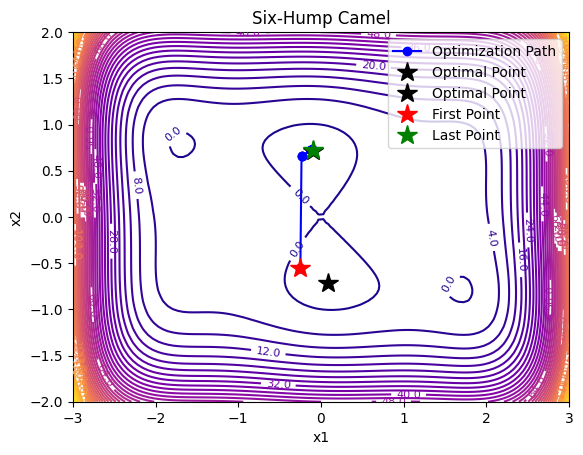

--------------------Iteration 2: --------------------
Iteration: 1 , Current Loss: -0.801314
Iteration: 2 , Current Loss: -0.801314
Iteration: 3 , Current Loss: -1.010883
Iteration: 4 , Current Loss: -1.010883
Iteration: 5 , Current Loss: -1.010883
Iteration: 6 , Current Loss: -1.010883
Iteration: 7 , Current Loss: -1.010883
Iteration: 8 , Current Loss: -1.010883
Iteration: 9 , Current Loss: -1.010883
Iteration: 10 , Current Loss: -1.010883
Iteration: 11 , Current Loss: -1.010883
Iteration: 12 , Current Loss: -1.010883
Iteration: 13 , Current Loss: -1.015657
Iteration: 14 , Current Loss: -1.02981
Iteration: 15 , Current Loss: -1.02981
Iteration: 16 , Current Loss: -1.02981
Iteration: 17 , Current Loss: -1.02981
Iteration: 18 , Current Loss: -1.02981
Iteration: 19 , Current Loss: -1.02981
Iteration: 20 , Current Loss: -1.02981
Iteration: 21 , Current Loss: -1.02981
Iteration: 22 , Current Loss: -1.02981
Iteration: 23 , Current Loss: -1.02981
Iteration: 24 , Current Loss: -1.02981
Iterat

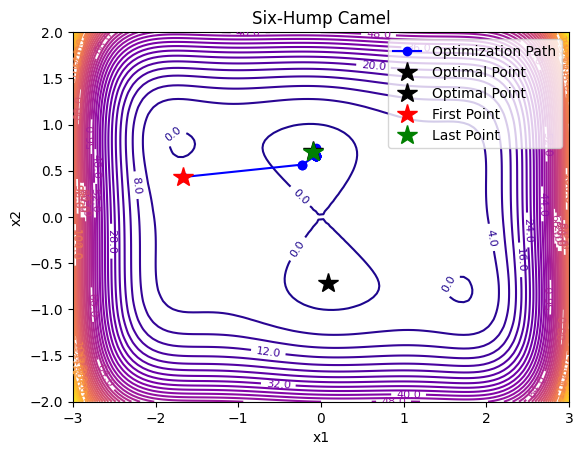

--------------------Iteration 3: --------------------
Iteration: 1 , Current Loss: 0.561869
Iteration: 2 , Current Loss: -0.256767
Iteration: 3 , Current Loss: -0.642788
Iteration: 4 , Current Loss: -0.642788
Iteration: 5 , Current Loss: -1.001185
Iteration: 6 , Current Loss: -1.001185
Iteration: 7 , Current Loss: -1.001185
Iteration: 8 , Current Loss: -1.022869
Iteration: 9 , Current Loss: -1.022869
Iteration: 10 , Current Loss: -1.022869
Iteration: 11 , Current Loss: -1.022869
Iteration: 12 , Current Loss: -1.022869
Iteration: 13 , Current Loss: -1.022869
Iteration: 14 , Current Loss: -1.022869
Iteration: 15 , Current Loss: -1.022869
Iteration: 16 , Current Loss: -1.023362
Iteration: 17 , Current Loss: -1.023362
Iteration: 18 , Current Loss: -1.023362
Iteration: 19 , Current Loss: -1.023362
Iteration: 20 , Current Loss: -1.023362
Iteration: 21 , Current Loss: -1.026222
Iteration: 22 , Current Loss: -1.026222
Iteration: 23 , Current Loss: -1.026222
Iteration: 24 , Current Loss: -1.029

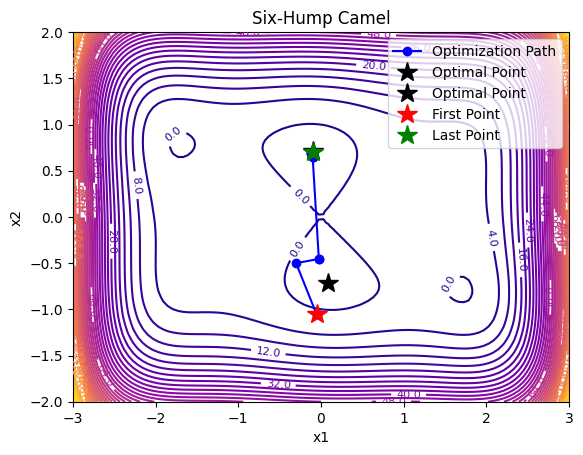

--------------------Iteration 4: --------------------
Iteration: 1 , Current Loss: 0.12306
Iteration: 2 , Current Loss: 0.085109
Iteration: 3 , Current Loss: -0.94181
Iteration: 4 , Current Loss: -0.96181
Iteration: 5 , Current Loss: -0.986684
Iteration: 6 , Current Loss: -0.986684
Iteration: 7 , Current Loss: -1.004664
Iteration: 8 , Current Loss: -1.004664
Iteration: 9 , Current Loss: -1.004664
Iteration: 10 , Current Loss: -1.004664
Iteration: 11 , Current Loss: -1.004664
Iteration: 12 , Current Loss: -1.004664
Iteration: 13 , Current Loss: -1.004664
Iteration: 14 , Current Loss: -1.004664
Iteration: 15 , Current Loss: -1.004664
Iteration: 16 , Current Loss: -1.004664
Iteration: 17 , Current Loss: -1.004664
Iteration: 18 , Current Loss: -1.004664
Iteration: 19 , Current Loss: -1.004664
Iteration: 20 , Current Loss: -1.004664
Iteration: 21 , Current Loss: -1.004664
Iteration: 22 , Current Loss: -1.004664
Iteration: 23 , Current Loss: -1.004664
Iteration: 24 , Current Loss: -1.004664


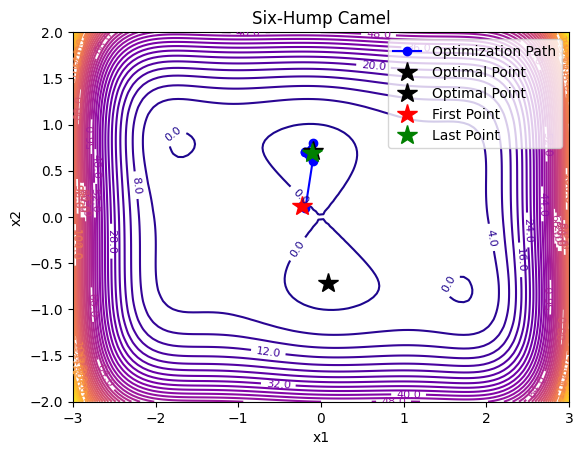

--------------------Iteration 5: --------------------
Iteration: 1 , Current Loss: -0.126042
Iteration: 2 , Current Loss: -0.866367
Iteration: 3 , Current Loss: -1.02981
Iteration: 4 , Current Loss: -1.02981
Iteration: 5 , Current Loss: -1.02981
Iteration: 6 , Current Loss: -1.02981
Iteration: 7 , Current Loss: -1.02981
Iteration: 8 , Current Loss: -1.02981
Iteration: 9 , Current Loss: -1.02981
Iteration: 10 , Current Loss: -1.02981
Iteration: 11 , Current Loss: -1.02981
Iteration: 12 , Current Loss: -1.02981
Iteration: 13 , Current Loss: -1.02981
Iteration: 14 , Current Loss: -1.02981
Iteration: 15 , Current Loss: -1.02981
Iteration: 16 , Current Loss: -1.02981
Iteration: 17 , Current Loss: -1.02981
Iteration: 18 , Current Loss: -1.02981
Iteration: 19 , Current Loss: -1.02981
Iteration: 20 , Current Loss: -1.02981
Iteration: 21 , Current Loss: -1.02981
Iteration: 22 , Current Loss: -1.02981
Iteration: 23 , Current Loss: -1.02981
Iteration: 24 , Current Loss: -1.02981
Iteration: 25 , C

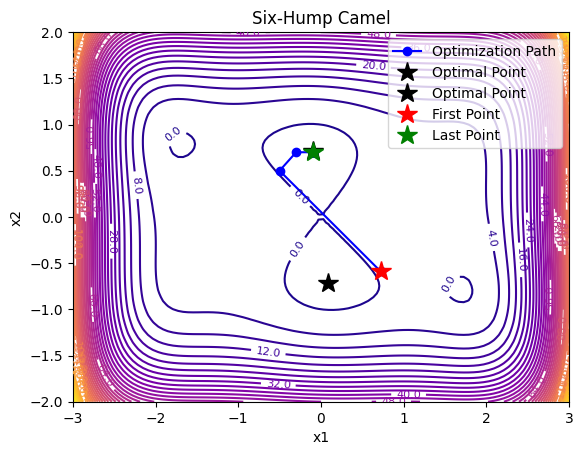

--------------------Iteration 6: --------------------
Iteration: 1 , Current Loss: -0.093027
Iteration: 2 , Current Loss: -0.093027
Iteration: 3 , Current Loss: -0.093027
Iteration: 4 , Current Loss: -0.315667
Iteration: 5 , Current Loss: -0.315667
Iteration: 6 , Current Loss: -0.33925
Iteration: 7 , Current Loss: -0.33925
Iteration: 8 , Current Loss: -0.37795
Iteration: 9 , Current Loss: -0.727705
Iteration: 10 , Current Loss: -0.727705
Iteration: 11 , Current Loss: -0.727705
Iteration: 12 , Current Loss: -0.727705
Iteration: 13 , Current Loss: -0.727705
Iteration: 14 , Current Loss: -0.727705
Iteration: 15 , Current Loss: -0.732023
Iteration: 16 , Current Loss: -0.795437
Iteration: 17 , Current Loss: -0.988245
Iteration: 18 , Current Loss: -0.988245
Iteration: 19 , Current Loss: -0.988245
Iteration: 20 , Current Loss: -0.988245
Iteration: 21 , Current Loss: -0.988245
Iteration: 22 , Current Loss: -0.988245
Iteration: 23 , Current Loss: -0.988245
Iteration: 24 , Current Loss: -0.99394

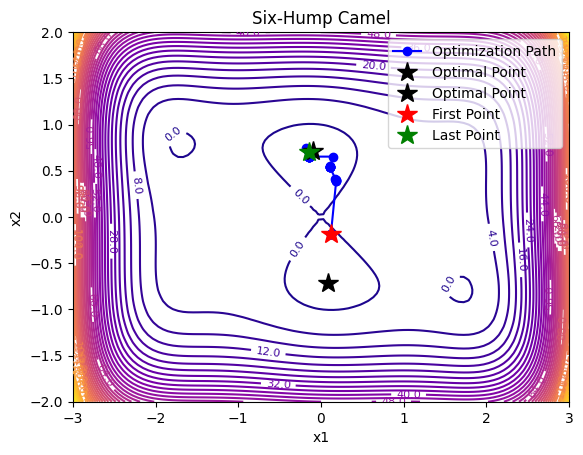

--------------------Iteration 7: --------------------
Iteration: 1 , Current Loss: -0.25781
Iteration: 2 , Current Loss: -0.25781
Iteration: 3 , Current Loss: -0.25781
Iteration: 4 , Current Loss: -1.021692
Iteration: 5 , Current Loss: -1.021692
Iteration: 6 , Current Loss: -1.021692
Iteration: 7 , Current Loss: -1.021692
Iteration: 8 , Current Loss: -1.021692
Iteration: 9 , Current Loss: -1.02981
Iteration: 10 , Current Loss: -1.02981
Iteration: 11 , Current Loss: -1.02981
Iteration: 12 , Current Loss: -1.02981
Iteration: 13 , Current Loss: -1.02981
Iteration: 14 , Current Loss: -1.02981
Iteration: 15 , Current Loss: -1.02981
Iteration: 16 , Current Loss: -1.02981
Iteration: 17 , Current Loss: -1.02981
Iteration: 18 , Current Loss: -1.02981
Iteration: 19 , Current Loss: -1.02981
Iteration: 20 , Current Loss: -1.02981
Iteration: 21 , Current Loss: -1.02981
Iteration: 22 , Current Loss: -1.02981
Iteration: 23 , Current Loss: -1.02981
Iteration: 24 , Current Loss: -1.02981
Iteration: 25 

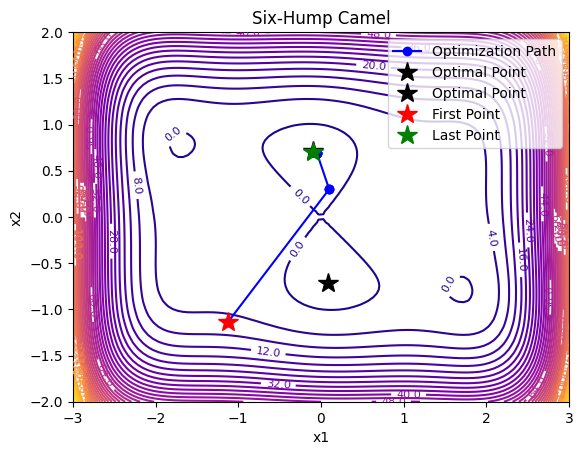

--------------------Iteration 8: --------------------
Iteration: 1 , Current Loss: 0.01019
Iteration: 2 , Current Loss: 0.01019
Iteration: 3 , Current Loss: -0.66021
Iteration: 4 , Current Loss: -0.66021
Iteration: 5 , Current Loss: -0.66021
Iteration: 6 , Current Loss: -0.9216
Iteration: 7 , Current Loss: -0.9216
Iteration: 8 , Current Loss: -0.9216
Iteration: 9 , Current Loss: -0.9216
Iteration: 10 , Current Loss: -0.9216
Iteration: 11 , Current Loss: -0.9216
Iteration: 12 , Current Loss: -0.94181
Iteration: 13 , Current Loss: -0.94181
Iteration: 14 , Current Loss: -1.00255
Iteration: 15 , Current Loss: -1.00255
Iteration: 16 , Current Loss: -1.00255
Iteration: 17 , Current Loss: -1.00255
Iteration: 18 , Current Loss: -1.00255
Iteration: 19 , Current Loss: -1.0035
Iteration: 20 , Current Loss: -1.011903
Iteration: 21 , Current Loss: -1.013109
Iteration: 22 , Current Loss: -1.01346
Iteration: 23 , Current Loss: -1.014372
Iteration: 24 , Current Loss: -1.015159
Iteration: 25 , Current 

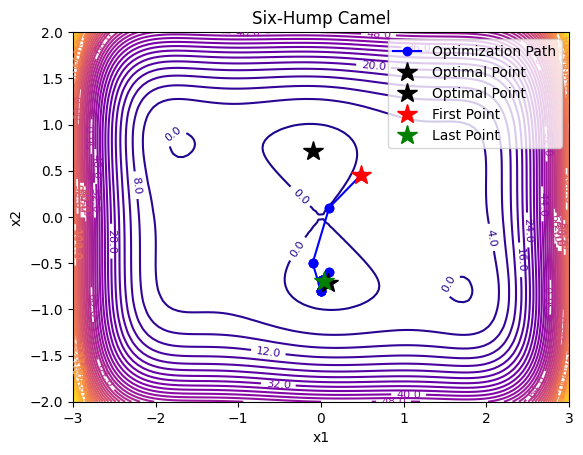

--------------------Iteration 9: --------------------
Iteration: 1 , Current Loss: -0.930649
Iteration: 2 , Current Loss: -0.930649
Iteration: 3 , Current Loss: -0.930649
Iteration: 4 , Current Loss: -0.930649
Iteration: 5 , Current Loss: -0.930649
Iteration: 6 , Current Loss: -0.930649
Iteration: 7 , Current Loss: -0.930649
Iteration: 8 , Current Loss: -0.930649
Iteration: 9 , Current Loss: -0.930649
Iteration: 10 , Current Loss: -0.930649
Iteration: 11 , Current Loss: -0.930649
Iteration: 12 , Current Loss: -0.963135
Iteration: 13 , Current Loss: -0.963135
Iteration: 14 , Current Loss: -0.963135
Iteration: 15 , Current Loss: -1.001553
Iteration: 16 , Current Loss: -1.001553
Iteration: 17 , Current Loss: -1.001553
Iteration: 18 , Current Loss: -1.001553
Iteration: 19 , Current Loss: -1.023854
Iteration: 20 , Current Loss: -1.023854
Iteration: 21 , Current Loss: -1.023854
Iteration: 22 , Current Loss: -1.023854
Iteration: 23 , Current Loss: -1.023854
Iteration: 24 , Current Loss: -1.02

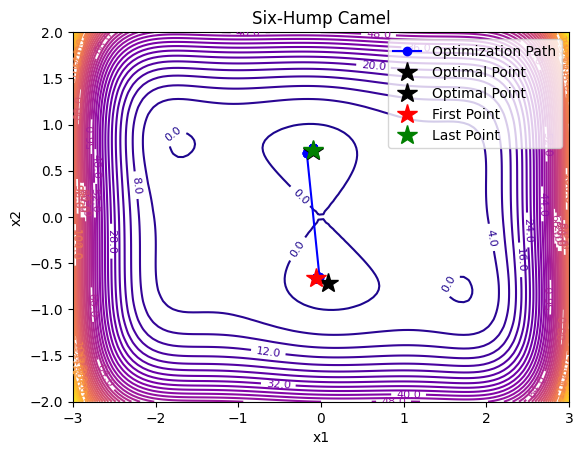

--------------------Iteration 10: --------------------
Iteration: 1 , Current Loss: 0.0
Iteration: 2 , Current Loss: 0.0
Iteration: 3 , Current Loss: -0.131755
Iteration: 4 , Current Loss: -0.790988
Iteration: 5 , Current Loss: -0.790988
Iteration: 6 , Current Loss: -0.790988
Iteration: 7 , Current Loss: -0.790988
Iteration: 8 , Current Loss: -0.790988
Iteration: 9 , Current Loss: -0.790988
Iteration: 10 , Current Loss: -0.896597
Iteration: 11 , Current Loss: -0.896597
Iteration: 12 , Current Loss: -1.01451
Iteration: 13 , Current Loss: -1.01451
Iteration: 14 , Current Loss: -1.01451
Iteration: 15 , Current Loss: -1.01451
Iteration: 16 , Current Loss: -1.01451
Iteration: 17 , Current Loss: -1.02981
Iteration: 18 , Current Loss: -1.02981
Iteration: 19 , Current Loss: -1.02981
Iteration: 20 , Current Loss: -1.02981
Iteration: 21 , Current Loss: -1.02981
Iteration: 22 , Current Loss: -1.02981
Iteration: 23 , Current Loss: -1.02981
Iteration: 24 , Current Loss: -1.02981
Iteration: 25 , Cur

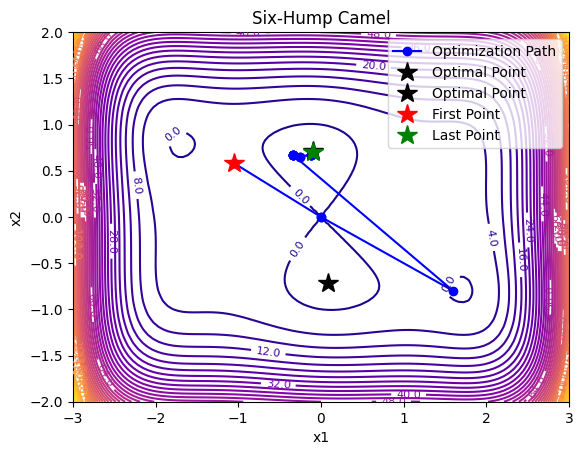

--------------------Iteration 11: --------------------
Iteration: 1 , Current Loss: -0.251754
Iteration: 2 , Current Loss: -0.347642
Iteration: 3 , Current Loss: -0.347642
Iteration: 4 , Current Loss: -0.666791
Iteration: 5 , Current Loss: -0.884939
Iteration: 6 , Current Loss: -0.884939
Iteration: 7 , Current Loss: -0.884939
Iteration: 8 , Current Loss: -0.924939
Iteration: 9 , Current Loss: -0.924939
Iteration: 10 , Current Loss: -0.924939
Iteration: 11 , Current Loss: -0.924939
Iteration: 12 , Current Loss: -0.924939
Iteration: 13 , Current Loss: -0.924939
Iteration: 14 , Current Loss: -0.924939
Iteration: 15 , Current Loss: -0.924939
Iteration: 16 , Current Loss: -0.945252
Iteration: 17 , Current Loss: -0.951471
Iteration: 18 , Current Loss: -0.951471
Iteration: 19 , Current Loss: -0.951471
Iteration: 20 , Current Loss: -0.951471
Iteration: 21 , Current Loss: -0.951471
Iteration: 22 , Current Loss: -0.985873
Iteration: 23 , Current Loss: -0.985873
Iteration: 24 , Current Loss: -0.9

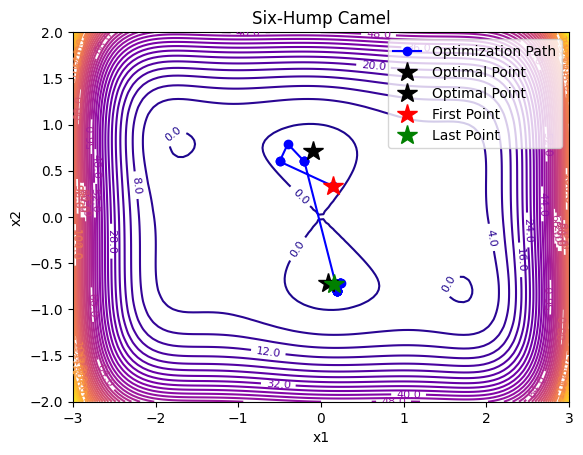

--------------------Iteration 12: --------------------
Iteration: 1 , Current Loss: -0.667329
Iteration: 2 , Current Loss: -0.68412
Iteration: 3 , Current Loss: -0.738268
Iteration: 4 , Current Loss: -0.745335
Iteration: 5 , Current Loss: -0.751739
Iteration: 6 , Current Loss: -0.771362
Iteration: 7 , Current Loss: -0.783077
Iteration: 8 , Current Loss: -0.805351
Iteration: 9 , Current Loss: -0.818142
Iteration: 10 , Current Loss: -0.82285
Iteration: 11 , Current Loss: -0.924715
Iteration: 12 , Current Loss: -0.924715
Iteration: 13 , Current Loss: -0.94181
Iteration: 14 , Current Loss: -0.94181
Iteration: 15 , Current Loss: -0.94181
Iteration: 16 , Current Loss: -0.94181
Iteration: 17 , Current Loss: -0.94181
Iteration: 18 , Current Loss: -0.94181
Iteration: 19 , Current Loss: -1.02981
Iteration: 20 , Current Loss: -1.02981
Iteration: 21 , Current Loss: -1.02981
Iteration: 22 , Current Loss: -1.02981
Iteration: 23 , Current Loss: -1.02981
Iteration: 24 , Current Loss: -1.02981
Iteratio

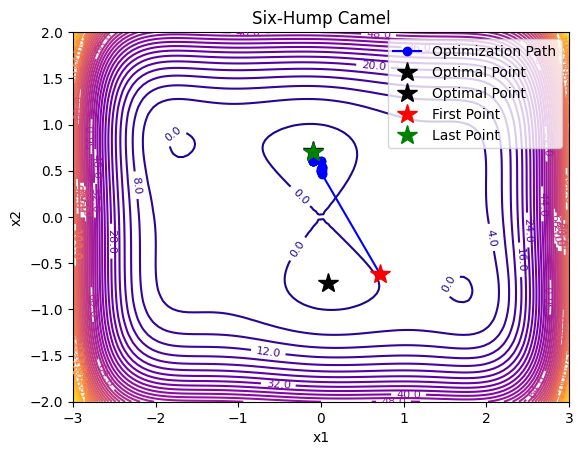

--------------------Iteration 13: --------------------
Iteration: 1 , Current Loss: 0.250848
Iteration: 2 , Current Loss: -0.007152
Iteration: 3 , Current Loss: -0.215154
Iteration: 4 , Current Loss: -0.215154
Iteration: 5 , Current Loss: -0.387995
Iteration: 6 , Current Loss: -0.387995
Iteration: 7 , Current Loss: -0.924939
Iteration: 8 , Current Loss: -0.924939
Iteration: 9 , Current Loss: -0.924939
Iteration: 10 , Current Loss: -0.924939
Iteration: 11 , Current Loss: -0.924939
Iteration: 12 , Current Loss: -0.924939
Iteration: 13 , Current Loss: -0.924939
Iteration: 14 , Current Loss: -0.924939
Iteration: 15 , Current Loss: -0.94181
Iteration: 16 , Current Loss: -0.94181
Iteration: 17 , Current Loss: -0.951613
Iteration: 18 , Current Loss: -0.951613
Iteration: 19 , Current Loss: -0.951613
Iteration: 20 , Current Loss: -0.951613
Iteration: 21 , Current Loss: -0.951613
Iteration: 22 , Current Loss: -0.984534
Iteration: 23 , Current Loss: -1.015659
Iteration: 24 , Current Loss: -1.0156

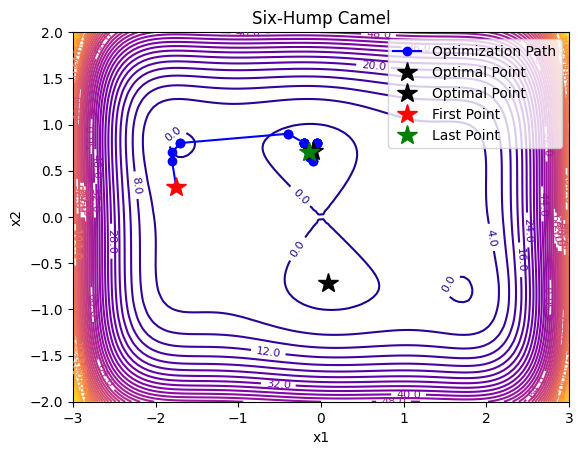

--------------------Iteration 14: --------------------
Iteration: 1 , Current Loss: 0.098918
Iteration: 2 , Current Loss: -0.109152
Iteration: 3 , Current Loss: -0.109152
Iteration: 4 , Current Loss: -0.109152
Iteration: 5 , Current Loss: -0.230939
Iteration: 6 , Current Loss: -0.982939
Iteration: 7 , Current Loss: -0.982939
Iteration: 8 , Current Loss: -0.982939
Iteration: 9 , Current Loss: -0.982939
Iteration: 10 , Current Loss: -0.982939
Iteration: 11 , Current Loss: -0.982939
Iteration: 12 , Current Loss: -0.982939
Iteration: 13 , Current Loss: -1.011888
Iteration: 14 , Current Loss: -1.011888
Iteration: 15 , Current Loss: -1.019585
Iteration: 16 , Current Loss: -1.019585
Iteration: 17 , Current Loss: -1.019585
Iteration: 18 , Current Loss: -1.019585
Iteration: 19 , Current Loss: -1.019585
Iteration: 20 , Current Loss: -1.019585
Iteration: 21 , Current Loss: -1.019585
Iteration: 22 , Current Loss: -1.019585
Iteration: 23 , Current Loss: -1.019585
Iteration: 24 , Current Loss: -1.01

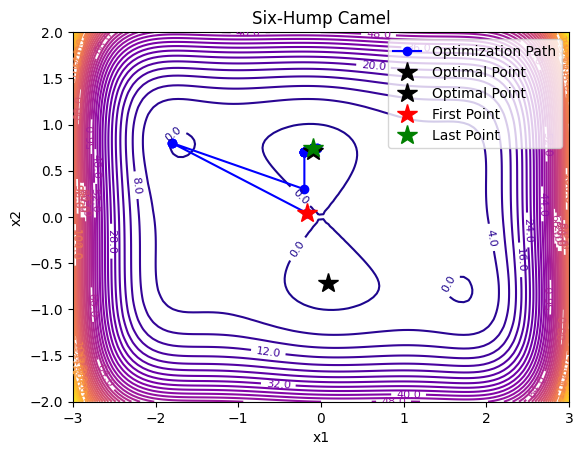

--------------------Iteration 15: --------------------
Iteration: 1 , Current Loss: 0.221915
Iteration: 2 , Current Loss: 0.0
Iteration: 3 , Current Loss: -0.126042
Iteration: 4 , Current Loss: -0.884939
Iteration: 5 , Current Loss: -0.884939
Iteration: 6 , Current Loss: -0.884939
Iteration: 7 , Current Loss: -0.884939
Iteration: 8 , Current Loss: -0.884939
Iteration: 9 , Current Loss: -0.884939
Iteration: 10 , Current Loss: -0.96181
Iteration: 11 , Current Loss: -0.9996
Iteration: 12 , Current Loss: -0.9996
Iteration: 13 , Current Loss: -0.9996
Iteration: 14 , Current Loss: -0.9996
Iteration: 15 , Current Loss: -0.9996
Iteration: 16 , Current Loss: -0.9996
Iteration: 17 , Current Loss: -0.9996
Iteration: 18 , Current Loss: -0.9996
Iteration: 19 , Current Loss: -0.9996
Iteration: 20 , Current Loss: -0.9996
Iteration: 21 , Current Loss: -0.9996
Iteration: 22 , Current Loss: -1.019585
Iteration: 23 , Current Loss: -1.019585
Iteration: 24 , Current Loss: -1.019585
Iteration: 25 , Current 

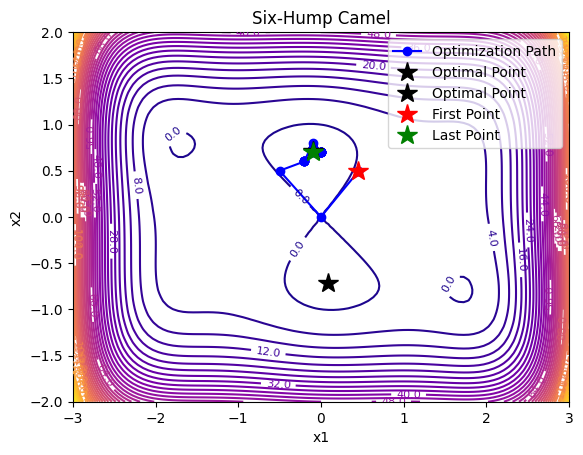

--------------------Iteration 16: --------------------
Iteration: 1 , Current Loss: -0.105383
Iteration: 2 , Current Loss: -0.105383
Iteration: 3 , Current Loss: -0.121886
Iteration: 4 , Current Loss: -0.44737
Iteration: 5 , Current Loss: -0.962854
Iteration: 6 , Current Loss: -0.962854
Iteration: 7 , Current Loss: -0.973102
Iteration: 8 , Current Loss: -0.978742
Iteration: 9 , Current Loss: -0.978742
Iteration: 10 , Current Loss: -0.978742
Iteration: 11 , Current Loss: -0.979911
Iteration: 12 , Current Loss: -0.985567
Iteration: 13 , Current Loss: -0.988796
Iteration: 14 , Current Loss: -0.997618
Iteration: 15 , Current Loss: -0.999228
Iteration: 16 , Current Loss: -0.999567
Iteration: 17 , Current Loss: -0.999658
Iteration: 18 , Current Loss: -0.999716
Iteration: 19 , Current Loss: -0.999788
Iteration: 20 , Current Loss: -0.999788
Iteration: 21 , Current Loss: -0.999788
Iteration: 22 , Current Loss: -1.003024
Iteration: 23 , Current Loss: -1.003024
Iteration: 24 , Current Loss: -1.00

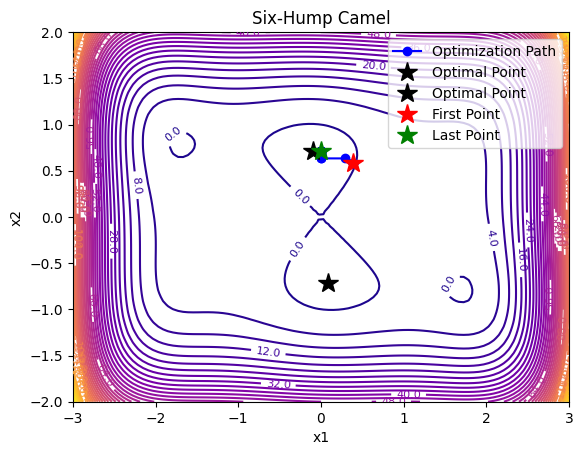

--------------------Iteration 17: --------------------
Iteration: 1 , Current Loss: -0.454349
Iteration: 2 , Current Loss: -0.457336
Iteration: 3 , Current Loss: -0.542563
Iteration: 4 , Current Loss: -0.556571
Iteration: 5 , Current Loss: -0.600608
Iteration: 6 , Current Loss: -0.600608
Iteration: 7 , Current Loss: -0.96181
Iteration: 8 , Current Loss: -0.96181
Iteration: 9 , Current Loss: -0.96181
Iteration: 10 , Current Loss: -0.975419
Iteration: 11 , Current Loss: -0.975419
Iteration: 12 , Current Loss: -0.975419
Iteration: 13 , Current Loss: -0.9951
Iteration: 14 , Current Loss: -0.9951
Iteration: 15 , Current Loss: -0.999078
Iteration: 16 , Current Loss: -0.999078
Iteration: 17 , Current Loss: -0.999078
Iteration: 18 , Current Loss: -0.999078
Iteration: 19 , Current Loss: -0.999078
Iteration: 20 , Current Loss: -0.999078
Iteration: 21 , Current Loss: -0.999078
Iteration: 22 , Current Loss: -0.999078
Iteration: 23 , Current Loss: -0.999078
Iteration: 24 , Current Loss: -0.999078
I

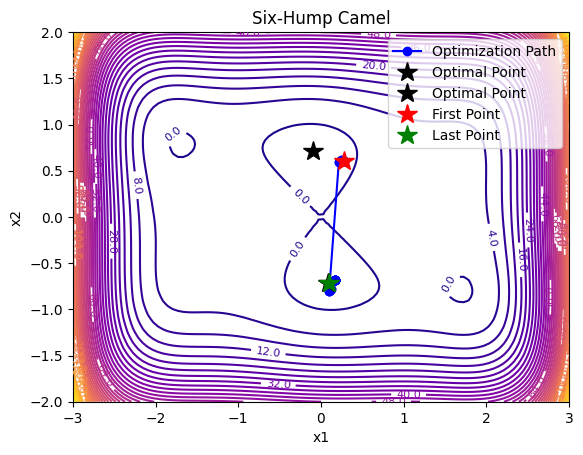

--------------------Iteration 18: --------------------
Iteration: 1 , Current Loss: -0.75
Iteration: 2 , Current Loss: -0.75
Iteration: 3 , Current Loss: -0.75
Iteration: 4 , Current Loss: -0.96181
Iteration: 5 , Current Loss: -0.96181
Iteration: 6 , Current Loss: -0.96181
Iteration: 7 , Current Loss: -1.02981
Iteration: 8 , Current Loss: -1.02981
Iteration: 9 , Current Loss: -1.02981
Iteration: 10 , Current Loss: -1.02981
Iteration: 11 , Current Loss: -1.02981
Iteration: 12 , Current Loss: -1.02981
Iteration: 13 , Current Loss: -1.02981
Iteration: 14 , Current Loss: -1.02981
Iteration: 15 , Current Loss: -1.02981
Iteration: 16 , Current Loss: -1.02981
Iteration: 17 , Current Loss: -1.02981
Iteration: 18 , Current Loss: -1.02981
Iteration: 19 , Current Loss: -1.02981
Iteration: 20 , Current Loss: -1.02981
Iteration: 21 , Current Loss: -1.02981
Iteration: 22 , Current Loss: -1.02981
Iteration: 23 , Current Loss: -1.02981
Iteration: 24 , Current Loss: -1.02981
Iteration: 25 , Current Los

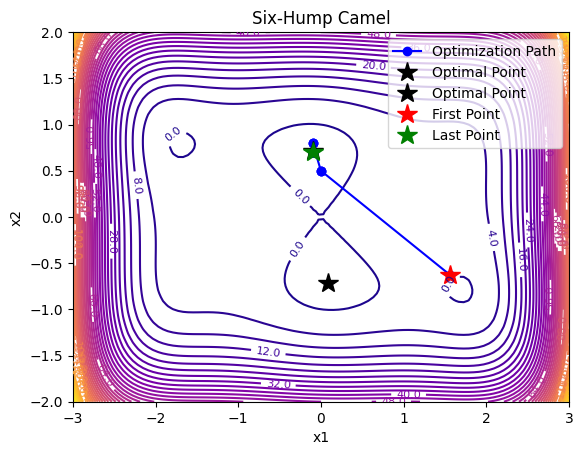

--------------------Iteration 19: --------------------
Iteration: 1 , Current Loss: 0.099471
Iteration: 2 , Current Loss: -0.128372
Iteration: 3 , Current Loss: -0.502651
Iteration: 4 , Current Loss: -0.502651
Iteration: 5 , Current Loss: -0.70792
Iteration: 6 , Current Loss: -0.884939
Iteration: 7 , Current Loss: -0.954613
Iteration: 8 , Current Loss: -0.954613
Iteration: 9 , Current Loss: -0.954613
Iteration: 10 , Current Loss: -0.954613
Iteration: 11 , Current Loss: -0.959488
Iteration: 12 , Current Loss: -0.960292
Iteration: 13 , Current Loss: -0.960292
Iteration: 14 , Current Loss: -0.960292
Iteration: 15 , Current Loss: -0.963687
Iteration: 16 , Current Loss: -0.96588
Iteration: 17 , Current Loss: -1.008422
Iteration: 18 , Current Loss: -1.008422
Iteration: 19 , Current Loss: -1.008422
Iteration: 20 , Current Loss: -1.008422
Iteration: 21 , Current Loss: -1.022096
Iteration: 22 , Current Loss: -1.022096
Iteration: 23 , Current Loss: -1.022096
Iteration: 24 , Current Loss: -1.0220

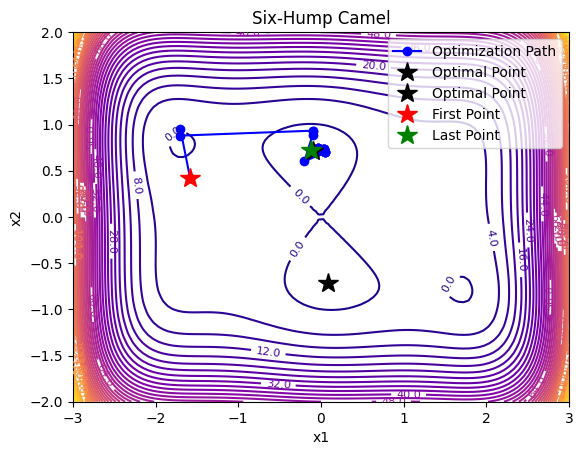

--------------------Iteration 20: --------------------
Iteration: 1 , Current Loss: -0.268317
Iteration: 2 , Current Loss: -0.268317
Iteration: 3 , Current Loss: -0.818367
Iteration: 4 , Current Loss: -0.996352
Iteration: 5 , Current Loss: -0.996352
Iteration: 6 , Current Loss: -0.996352
Iteration: 7 , Current Loss: -0.996352
Iteration: 8 , Current Loss: -0.996352
Iteration: 9 , Current Loss: -0.996352
Iteration: 10 , Current Loss: -0.996352
Iteration: 11 , Current Loss: -0.996352
Iteration: 12 , Current Loss: -1.018739
Iteration: 13 , Current Loss: -1.018739
Iteration: 14 , Current Loss: -1.020946
Iteration: 15 , Current Loss: -1.020946
Iteration: 16 , Current Loss: -1.020946
Iteration: 17 , Current Loss: -1.023188
Iteration: 18 , Current Loss: -1.024688
Iteration: 19 , Current Loss: -1.024688
Iteration: 20 , Current Loss: -1.025217
Iteration: 21 , Current Loss: -1.025217
Iteration: 22 , Current Loss: -1.025217
Iteration: 23 , Current Loss: -1.025217
Iteration: 24 , Current Loss: -1.0

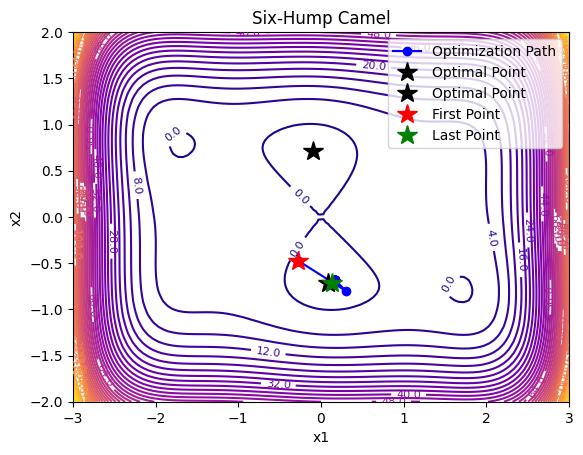

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# The main Code
# parameters
n_explore = 10
n_exploit = 10
n_explore_to_exploit = 1
n_iter = 30
n_dimension = 2
# initial point generation
# multiple iterations
from google.colab import files
n_iter_max = 20
df_history_all = pd.DataFrame()
for iter_max in range(n_iter_max):
  print(f"{'-' * 20}Iteration {iter_max+1}: {'-' * 20}")
  # initialization
  df_init_fc = np.random.uniform(xmin, xmax, size=n_explore)
  df_init_sc = np.random.uniform(ymin, ymax, size=n_explore)
  data_init = np.column_stack((df_init_fc, df_init_sc))
  df_init = pd.DataFrame(data_init, columns=['x1', 'x2'])
  df_init['loss'] = df_init.apply(lambda row: func(row['x1'], row['x2']), axis=1)
  df_init = df_init.round(6)
  loss_iter = []
  df_history = pd.DataFrame(columns=['x1', 'x2'])
  min_solution_init,min_loss_init = solution_min_loss(df_init,'loss')
  min_solution_init["Iteration"] = iter_max + 1
  if not df_history.empty:
    df_history = pd.concat([df_history, min_solution_init], ignore_index=True)
  else:
    df_history = min_solution_init.copy()
  LEO_explore_point = df_init.copy()
  LEO_exploit_point = df_init.copy()
  for iter in range(n_iter):
    # Explore
    explore_prompt = llm_agent_LEO_explore(LEO_explore_point)
    explore_messages = [
        HumanMessage(content=explore_prompt)
    ]
    llm_explore_output = chain.invoke(explore_messages)
    explore_result = llm_extract_csv_wo_bounds(llm_explore_output,['x1', 'x2'])
    explore_result['loss'] = explore_result.apply(lambda row: func(row['x1'], row['x2']), axis=1)
    LEO_explore_point = solution_merge_sort(LEO_explore_point,explore_result,n_explore,'loss')
    # Exploit
    exploit_prompt = llm_agent_LEO_exploit(LEO_exploit_point)
    exploit_messages = [
        HumanMessage(content=exploit_prompt)
    ]
    llm_exploit_output = chain.invoke(exploit_messages)
    exploit_result = llm_extract_csv_wo_bounds(llm_exploit_output,['x1', 'x2'])
    exploit_result['loss'] = exploit_result.apply(lambda row: func(row['x1'], row['x2']), axis=1)
    exploit_sorted_top = solution_merge_sort(LEO_exploit_point,exploit_result,n_exploit,'loss')
    LEO_exploit_point = solution_drop_merge_sort(LEO_explore_point,exploit_sorted_top,n_exploit,n_explore_to_exploit,'loss')
    # Memory
    min_solution,min_loss = solution_min_loss(LEO_exploit_point,'loss')
    loss_iter.append(float(min_loss))
    min_solution["Iteration"] = iter_max + 1
    df_history = pd.concat([df_history, min_solution], ignore_index=True)
    print('Iteration:',iter+1,', Current Loss:', min_loss)
  loss_vector = np.array(loss_iter)
  loss_df = pd.DataFrame(loss_vector,columns=['loss'])
  # draw figure
  figure_drawer(df_history,parameter_list,optimal_point_list,func_title)
  df_history_all = pd.concat([df_history_all, df_history])
df_history_all.to_csv('all_iterations_history.csv', index=False)
files.download("all_iterations_history.csv")

In [ ]:
df_history_all.to_csv('all_iterations_history.csv', index=False)
files.download("all_iterations_history.csv")